In [1]:
import os
import torch
import itertools
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from typing import List, Tuple, Dict
import os 
from tqdm import tqdm
import random

In [3]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


* **Getting the train and test dataset**

In [5]:
BATCH_SIZE = 1

# Define the Transform class
class Transform():
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define the SeismicDataset class
class SeismicDataset(Dataset):
    def __init__(self, elastic_patches, acoustic_patches):
        self.elastic_patches = elastic_patches
        self.acoustic_patches = acoustic_patches
        self.trasformer = Transform()

    def __len__(self):
        return len(self.elastic_patches)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        elastic_patch = self.elastic_patches[idx]
        acoustic_patch = self.acoustic_patches[idx]
        elastic_patch  = self.trasformer(elastic_patch)
        acoustic_patch = self.trasformer(acoustic_patch)
        return elastic_patch, acoustic_patch

# Function to load binary data
def load_bin_data(file, samples):
    data = np.fromfile(file, dtype='float32')
    nrecs = data.size // samples
    data = data.reshape(nrecs, samples).T
    return data

def preprocess_patches(patches):
    # Normalize and add channel dimension for grayscale images
    max = abs(np.max(patches))
    min = abs(np.min(patches))
    maxi = np.max([max, min])
    patches = patches/maxi  # Normalize to [-1, 1]
    return patches[..., np.newaxis]  # Add channel dimension

# Function to split data into patches
def split_into_patches(data, patch_size=256, vertical_overlap=0, horizontal_overlap=0):
    step_h = patch_size - horizontal_overlap
    step_v = patch_size - vertical_overlap
    patches = []
    for i in range(0, data.shape[0] - patch_size + 1, step_v):
        for j in range(0, data.shape[1] - patch_size + 1, step_h):
            patch = data[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return np.array(patches)

# Function to remove all-zero patches and maintain pairing
def remove_zero_and_same_value_patches(elastic_patches, acoustic_patches):
    paired_patches = []
    for e_patch, a_patch in zip(elastic_patches, acoustic_patches):
        if not np.all(e_patch <= 1e-4) and not np.all(a_patch <= 1e-4) and \
           len(np.unique(e_patch)) > 1 and len(np.unique(a_patch)) > 1:
            paired_patches.append((e_patch, a_patch))
    
    # Unzip the list of tuples back into separate arrays
    elastic_patches, acoustic_patches = zip(*paired_patches)
    return np.array(elastic_patches), np.array(acoustic_patches)

# Function to process folder
def process_folder(data_dir_elastic, data_dir_acoustic, idx_train, samples=768, patch_size=256):
    all_data_train_elastic = []
    all_data_test_elastic = []
    all_data_train_acoustic = []
    all_data_test_acoustic = []

    # Combine elasticdata and acousticdata based on idx_train
    for idx in range(1,362):
        elastic_file = f"Elasticdata{idx}.bin"
        if idx in idx_train:
            data = load_bin_data(os.path.join(data_dir_elastic, elastic_file), samples)
            all_data_train_elastic.append(data)
        else:
            data = load_bin_data(os.path.join(data_dir_elastic, elastic_file), samples)
            all_data_test_elastic.append(data)

    for idx in range(1,362):
        acoustic_file = f"Acusticdata{idx}.bin"
        if idx in idx_train:
            data = load_bin_data(os.path.join(data_dir_acoustic, acoustic_file), samples)
            all_data_train_acoustic.append(data)
        else:
            data = load_bin_data(os.path.join(data_dir_acoustic, acoustic_file), samples)
            all_data_test_acoustic.append(data)

    print(f'Train seismograms length : {len(all_data_train_elastic)}')
    print(f'Train seismograms length : {len(all_data_train_acoustic)}')

    return np.array(all_data_train_elastic), np.array(all_data_test_elastic), np.array(all_data_train_acoustic), np.array(all_data_test_acoustic)

# Paths to the directories
elastic_dir = r'C:\Users\Matheus\TrabalhodeMestrado\Redes Neurais\Dados\Seismic_data\Elastic_data\Pfield'
acoustic_dir = r'C:\Users\Matheus\TrabalhodeMestrado\Redes Neurais\Dados\Seismic_data\Acustic_data\Pfield'

# 80% of the files are used for training
n_train = 300
idx_train = np.sort(random.sample(range(1, 361), n_train))

# Load and separate data
train_elastic, test_elastic, train_acoustic, test_acoustic = process_folder(elastic_dir, acoustic_dir, idx_train)

# Split training data into patches
vertical_overlap = 128 # five vertical windowns
horizontal_overlap = 151 # two horizontal windowns
patch_size = 256
train_elastic_patches = np.concatenate([split_into_patches(data, patch_size, vertical_overlap, horizontal_overlap ) for data in train_elastic])
train_acoustic_patches = np.concatenate([split_into_patches(data, patch_size, vertical_overlap, horizontal_overlap ) for data in train_acoustic])

# Preprocess and create datasets
test_elastic_patches = preprocess_patches(test_elastic)
test_acoustic_patches = preprocess_patches(test_acoustic)
train_elastic_patches = preprocess_patches(train_elastic_patches)
train_acoustic_patches = preprocess_patches(train_acoustic_patches)

# # Remove zero patches and maintain pairing
# train_elastic_patches, train_acoustic_patches = remove_zero_and_same_value_patches(train_elastic_patches, train_acoustic_patches)
# test_elastic_patches, test_acoustic_patches = remove_zero_and_same_value_patches(test_elastic_patches, test_acoustic_patches)

# Create the dataset with paired data
test_ds = SeismicDataset(test_acoustic_patches, test_elastic_patches)
train_ds = SeismicDataset(train_acoustic_patches, train_elastic_patches)

# Create the DataLoader with the desired parameters
BATCH_SIZE = 1
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Train seismograms length : 300
Train seismograms length : 300


In [7]:
# Número total de patches no dataset de treino
num_train_patches = len(train_ds)
num_test_patches = len(test_ds)

# Número de batches no DataLoader
num_train_batches = len(train_dl)
num_test_batches = len(test_dl)

print(f"Número total de patches de treino: {num_train_patches}")
print(f"Número total de patches de teste: {num_test_patches}")
print(f"Número total de batches de treino: {num_train_batches}")
print(f"Número total de batches de teste: {num_test_batches}")

Número total de patches de treino: 3000
Número total de patches de teste: 61
Número total de batches de treino: 3000
Número total de batches de teste: 61


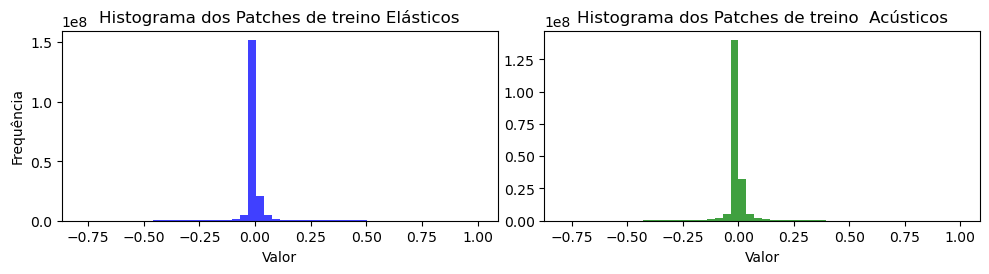

In [9]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in train_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de treino Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de treino  Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

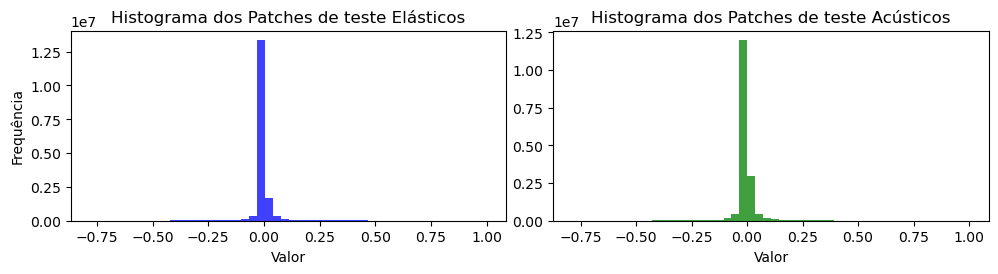

In [10]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in test_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

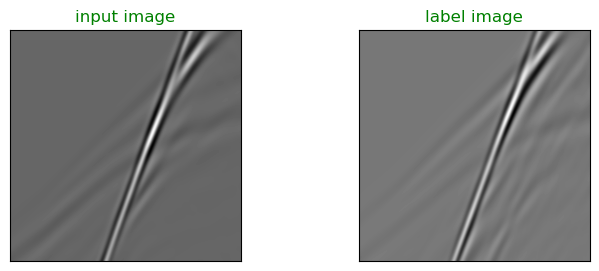

In [17]:
def show_img_sample(train_dl):
    for i, (real_input, real_target) in enumerate(train_dl):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_input[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_input[0].squeeze(), cmap='gray')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("input image", c="g")
        ax[1].imshow(real_target[0].squeeze(), cmap='gray')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("label image", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(train_dl)

* **Define the generator and discriminator**

In [19]:
class GeneratorUnet(nn.Module):
    def __init__(self, in_channels):
        super(GeneratorUnet, self).__init__()
        self.down_stack = nn.ModuleList([
            self.Downsample(in_channels, 64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            self.Downsample(64, 128),  # (batch_size, 64, 64, 128)
            self.Downsample(128, 256),  # (batch_size, 32, 32, 256)
            self.Downsample(256, 512),  # (batch_size, 16, 16, 512)
            self.Downsample(512, 512),  # (batch_size, 8, 8, 512)
            self.Downsample(512, 512),  # (batch_size, 4, 4, 512)
            self.Downsample(512, 512),  # (batch_size, 2, 2, 512)
            self.Downsample(512, 512, apply_batchnorm=False),  # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            self.Upsample(512, 512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            self.Upsample(1024, 512),  # (batch_size, 16, 16, 1024)
            self.Upsample(1024, 256),  # (batch_size, 32, 32, 512)
            self.Upsample(512, 128),  # (batch_size, 64, 64, 256)
            self.Upsample(256, 64),  # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def Downsample(self, in_channels, out_channels, apply_batchnorm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def Upsample(self, in_channels, out_channels, apply_dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        return nn.Sequential(*layers)

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32     
            nn.ZeroPad2d(1), # padding left and top   256*32*32 -> 256*34*34
            nn.Conv2d(256, 512, 4, stride=1, bias=False), #256*34*34 -> 512*31*31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d(1), #512*31*31 -> 512*33*33
            nn.Conv2d(512, 1, 4) #512*33*33 -> 1*30*30
        )
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, input, target):
        x = torch.cat((input, target), dim=1)
        return self.model(x)

* **Define the Loss**

In [24]:
criterion_L1  = nn.L1Loss() # Perda L1
criterion_GAN = nn.BCEWithLogitsLoss() # Perda quadrática

* **Inicializando os modelos na GPU**

In [27]:
G = GeneratorUnet(1)
D = Discriminator(2)

In [29]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G = G.cuda()
    D = D.cuda()
    
    criterion_L1 = criterion_L1.cuda()
    criterion_GAN = criterion_GAN.cuda()

cuda: True


In [30]:
def visualize_data(generator, discriminator, dataloader, title, device):
    generator.eval()  # Coloca o gerador no modo de avaliação
    discriminator.eval()  # Coloca o discriminador no modo de avaliação

    # Itera através do dataloader
    for i, (real_input, real_target) in enumerate(dataloader):
        if i > 0:
          break

        real_input, real_target = real_input.to(device), real_target.to(device)

        # Gera imagens falsas com o gerador
        with torch.no_grad():
            fake_image = generator(real_input)

        # Avalia as imagens reais e falsas com o discriminador
        real_output = discriminator(real_input,real_target)
        fake_output = discriminator(real_input,fake_image.detach())

        print(f'shape da saída do gerador {fake_image.shape}')
        print(f'shape da saída do discriminador {fake_output.shape}')

        # Visualiza os resultados
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{title}')

        # Converte os tensores de volta para imagens no intervalo [0, 1]
        real_input_img = (real_input[0].cpu().permute(1, 2, 0) + 1) / 2
        real_target_img = (real_target[0].cpu().permute(1, 2, 0) + 1) / 2
        fake_image_img = (fake_image[0].cpu().permute(1, 2, 0) + 1) / 2

       # Mostra a imagem de entrada (real)
        im1 = ax[0].imshow(real_input_img)
        ax[0].set_title('Real Input')
        ax[0].axis('off')

        # Mostra a imagem real alvo (ground truth)
        im2 = ax[1].imshow(real_target_img)
        ax[1].set_title('Real Target')
        ax[1].axis('off')

        # Mostra a imagem falsa gerada
        im3 = ax[2].imshow(fake_image_img)
        ax[2].set_title('Generated Image')
        ax[2].axis('off')

       # # Desconecta os tensores e converte para numpy antes de exibir
       #  real_output_img = real_output[0, 0].detach().cpu().numpy()
       #  fake_output_img = fake_output[0, 0].detach().cpu().numpy()

       #  # Mostra o resultado do discriminador para a imagem real
       #  im1 = ax[1, 0].imshow(real_output_img, cmap='RdBu_r')
       #  ax[1, 0].set_title('Discriminator Output (Real Target)')
       #  ax[1, 0].axis('off')

       #  # Mostra o resultado do discriminador para a imagem gerada
       #  im2 = ax[1, 1].imshow(fake_output_img, cmap='RdBu_r')
       #  ax[1, 1].set_title('Discriminator Output (Generated Image)')
       #  ax[1, 1].axis('off')

        fig.colorbar(im1, ax=ax[0])
        fig.colorbar(im2, ax=ax[1])
        fig.colorbar(im3, ax=ax[2])

        plt.tight_layout()
        plt.show()

shape da saída do gerador torch.Size([1, 1, 256, 256])
shape da saída do discriminador torch.Size([1, 1, 30, 30])


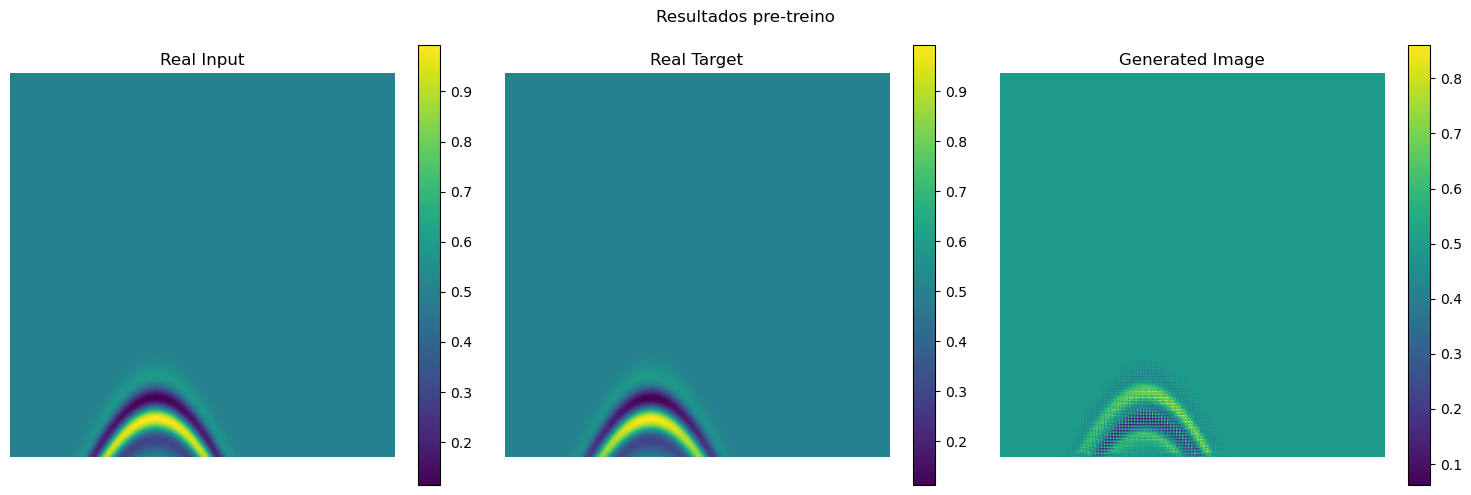

In [33]:
visualize_data(G, D, train_dl, 'Resultados pre-treino', device)

In [37]:
lr_G = 2e-4
lr_D = 2e-4
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(b1, b2))

In [39]:
n_epoches = 100
decay_epoch = 90 # Reference paper
G_losses, D_losses, L1_losses, GAN_losses = [], [], [], []

# lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)
# lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
# lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_func)

for epoch in range(n_epoches):

    G.train()
    D.train()
    LAMBDA = 1000

    for i, (input, target) in enumerate(tqdm(train_dl)):
        input, target = input.to(device), target.to(device)

        real_label = torch.ones_like(D(input, target), device=device)  # Rótulo para imagens reais
        fake_label = torch.zeros_like(D(input, target), device=device) 
        
        fake_image = G(input)
        fake_image_ = fake_image.detach()

        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode

        optimizer_G.zero_grad()

        # GAN loss, train G to make D think it's true
        loss_L1 = criterion_L1(fake_image, target)
        loss_GAN = criterion_GAN(D(input, fake_image), real_label) # Não pode usar o fake_image_ aqui, pois o gerador precisa calcular o gradiente com basse na imagem fake
        
        # G total loss
        loss_G = loss_GAN + LAMBDA * loss_L1 

        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator """
        optimizer_D.zero_grad()
        
        loss_real = criterion_GAN(D(input, target), real_label)
        loss_fake = criterion_GAN(D(input, fake_image_), fake_label)
        loss_D = (loss_real + loss_fake) * 0.5
        
        loss_D.backward()
        optimizer_D.step()
        
    # lr_scheduler_G.step()
    # lr_scheduler_D.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    GAN_losses.append(loss_GAN.item())
    L1_losses.append(loss_L1.item())

    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | GAN: {loss_GAN.item()} L1: {loss_L1.item()}]')
    print(f'[D loss: {loss_D.item()}]')

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.12it/s]


[Epoch 1/100]
[G loss: 10.04751968383789 | GAN: 1.502697229385376 L1: 0.008544822223484516]
[D loss: 0.29168567061424255]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:53<00:00, 26.50it/s]


[Epoch 2/100]
[G loss: 11.470443725585938 | GAN: 5.776172161102295 L1: 0.005694271996617317]
[D loss: 0.01758396625518799]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.65it/s]


[Epoch 3/100]
[G loss: 9.808640480041504 | GAN: 5.225915908813477 L1: 0.004582724533975124]
[D loss: 0.010232727974653244]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.27it/s]


[Epoch 4/100]
[G loss: 4.020661354064941 | GAN: 3.949129343032837 L1: 7.153199112508446e-05]
[D loss: 0.01874586008489132]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.17it/s]


[Epoch 5/100]
[G loss: 9.625240325927734 | GAN: 5.910000324249268 L1: 0.0037152401637285948]
[D loss: 0.004934573080390692]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:55<00:00, 25.96it/s]


[Epoch 6/100]
[G loss: 14.293848037719727 | GAN: 8.718210220336914 L1: 0.005575638264417648]
[D loss: 0.0006915741832926869]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.30it/s]


[Epoch 7/100]
[G loss: 13.323007583618164 | GAN: 6.483615398406982 L1: 0.006839391775429249]
[D loss: 0.00336623378098011]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.17it/s]


[Epoch 8/100]
[G loss: 11.734709739685059 | GAN: 6.961606025695801 L1: 0.004773103632032871]
[D loss: 0.002489271108061075]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.20it/s]


[Epoch 9/100]
[G loss: 0.7321113348007202 | GAN: 0.7321113348007202 L1: 6.752598271581506e-17]
[D loss: 0.6966433525085449]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:53<00:00, 26.33it/s]


[Epoch 10/100]
[G loss: 14.508024215698242 | GAN: 8.981945991516113 L1: 0.00552607886493206]
[D loss: 0.0008202616008929908]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.21it/s]


[Epoch 11/100]
[G loss: 11.834918022155762 | GAN: 9.314665794372559 L1: 0.00252025225199759]
[D loss: 0.0003491195384413004]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.18it/s]


[Epoch 12/100]
[G loss: 10.02674674987793 | GAN: 8.361666679382324 L1: 0.0016650796169415116]
[D loss: 0.0006496029673144221]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:55<00:00, 26.08it/s]


[Epoch 13/100]
[G loss: 8.981512069702148 | GAN: 6.135861873626709 L1: 0.0028456496074795723]
[D loss: 0.0024795385543257]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.19it/s]


[Epoch 14/100]
[G loss: 10.012292861938477 | GAN: 6.4448394775390625 L1: 0.003567453008145094]
[D loss: 0.0017252254765480757]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:54<00:00, 26.28it/s]


[Epoch 15/100]
[G loss: 4.917887210845947 | GAN: 4.226208209991455 L1: 0.0006916789570823312]
[D loss: 0.012531139887869358]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:53<00:00, 26.47it/s]


[Epoch 16/100]
[G loss: 13.602749824523926 | GAN: 10.697710990905762 L1: 0.0029050391167402267]
[D loss: 0.0001050664868671447]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:53<00:00, 26.37it/s]


[Epoch 17/100]
[G loss: 5.36904764175415 | GAN: 5.351665496826172 L1: 1.7382120859110728e-05]
[D loss: 0.026564422994852066]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.63it/s]


[Epoch 18/100]
[G loss: 11.443748474121094 | GAN: 7.261460304260254 L1: 0.00418228842318058]
[D loss: 0.0013281716965138912]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.61it/s]


[Epoch 19/100]
[G loss: 8.778629302978516 | GAN: 6.436728477478027 L1: 0.0023419014178216457]
[D loss: 0.017380211502313614]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.63it/s]


[Epoch 20/100]
[G loss: 8.24717903137207 | GAN: 3.8803839683532715 L1: 0.004366794601082802]
[D loss: 0.031234823167324066]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 21/100]
[G loss: 13.585904121398926 | GAN: 10.653922080993652 L1: 0.0029319822788238525]
[D loss: 3.92054244002793e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.79it/s]


[Epoch 22/100]
[G loss: 4.217320442199707 | GAN: 2.7219390869140625 L1: 0.0014953811187297106]
[D loss: 0.0826118215918541]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.79it/s]


[Epoch 23/100]
[G loss: 12.970975875854492 | GAN: 11.720601081848145 L1: 0.0012503747129812837]
[D loss: 0.0008767193066887558]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 24/100]
[G loss: 5.410722255706787 | GAN: 4.661251068115234 L1: 0.0007494713645428419]
[D loss: 0.00847673136740923]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 25/100]
[G loss: 11.832496643066406 | GAN: 7.817659854888916 L1: 0.004014836624264717]
[D loss: 0.0009855704847723246]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.80it/s]


[Epoch 26/100]
[G loss: 10.947400093078613 | GAN: 7.594579696655273 L1: 0.0033528204075992107]
[D loss: 0.0004467735125217587]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.76it/s]


[Epoch 27/100]
[G loss: 8.689830780029297 | GAN: 4.4851274490356445 L1: 0.0042047034949064255]
[D loss: 0.3070172369480133]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.62it/s]


[Epoch 28/100]
[G loss: 13.4932861328125 | GAN: 9.273032188415527 L1: 0.00422025378793478]
[D loss: 0.0001947639393620193]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 29/100]
[G loss: 7.427463531494141 | GAN: 5.978615760803223 L1: 0.0014488475862890482]
[D loss: 0.00801051128655672]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 30/100]
[G loss: 12.990135192871094 | GAN: 8.139071464538574 L1: 0.004851063247770071]
[D loss: 0.0004519440117292106]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 31/100]
[G loss: 9.850317001342773 | GAN: 8.409659385681152 L1: 0.0014406575355678797]
[D loss: 0.00035307195503264666]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.79it/s]


[Epoch 32/100]
[G loss: 0.7019017338752747 | GAN: 0.7019017338752747 L1: 1.8222656863282546e-14]
[D loss: 0.6952848434448242]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.79it/s]


[Epoch 33/100]
[G loss: 5.184480667114258 | GAN: 4.3123931884765625 L1: 0.0008720873156562448]
[D loss: 0.009632138535380363]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 34/100]
[G loss: 9.212265968322754 | GAN: 8.344817161560059 L1: 0.0008674488635733724]
[D loss: 0.0018602687632665038]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 35/100]
[G loss: 6.713464736938477 | GAN: 6.658524990081787 L1: 5.4939533583819866e-05]
[D loss: 0.001184228342026472]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.79it/s]


[Epoch 36/100]
[G loss: 14.195768356323242 | GAN: 9.528316497802734 L1: 0.004667452536523342]
[D loss: 0.002392734866589308]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 37/100]
[G loss: 13.762128829956055 | GAN: 9.434386253356934 L1: 0.004327742382884026]
[D loss: 0.000337046105414629]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 38/100]
[G loss: 0.7774418592453003 | GAN: 0.7774418592453003 L1: 1.411167478037505e-17]
[D loss: 0.7403292655944824]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 39/100]
[G loss: 14.37904167175293 | GAN: 10.413802146911621 L1: 0.00396523904055357]
[D loss: 0.0006392573122866452]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 40/100]
[G loss: 7.295044898986816 | GAN: 5.651646137237549 L1: 0.0016433985438197851]
[D loss: 0.004955270327627659]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.79it/s]


[Epoch 41/100]
[G loss: 17.808170318603516 | GAN: 13.119863510131836 L1: 0.004688306245952845]
[D loss: 0.001490312977693975]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 42/100]
[G loss: 9.15627670288086 | GAN: 4.206366539001465 L1: 0.004949910566210747]
[D loss: 0.02027076855301857]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 43/100]
[G loss: 10.374181747436523 | GAN: 6.0296735763549805 L1: 0.004344508517533541]
[D loss: 0.00392601964995265]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 44/100]
[G loss: 0.7919660806655884 | GAN: 0.7919660806655884 L1: 1.0813052337636163e-38]
[D loss: 0.7050415277481079]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 45/100]
[G loss: 12.639710426330566 | GAN: 8.647981643676758 L1: 0.003991729114204645]
[D loss: 0.0002739476622082293]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 46/100]
[G loss: 12.506158828735352 | GAN: 11.125213623046875 L1: 0.0013809454394504428]
[D loss: 8.082931162789464e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 47/100]
[G loss: 17.09480857849121 | GAN: 13.900162696838379 L1: 0.003194645745679736]
[D loss: 2.976253927045036e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 48/100]
[G loss: 9.452207565307617 | GAN: 7.190025329589844 L1: 0.0022621825337409973]
[D loss: 0.0010942805092781782]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 49/100]
[G loss: 10.05150032043457 | GAN: 9.112112045288086 L1: 0.0009393885848112404]
[D loss: 0.0007639685645699501]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 50/100]
[G loss: 9.672362327575684 | GAN: 5.529097557067871 L1: 0.00414326461032033]
[D loss: 0.0071600982919335365]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 51/100]
[G loss: 16.394733428955078 | GAN: 12.55228328704834 L1: 0.0038424506783485413]
[D loss: 0.00031836103880777955]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 52/100]
[G loss: 13.773866653442383 | GAN: 8.223306655883789 L1: 0.005550559610128403]
[D loss: 0.00047002476640045643]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 53/100]
[G loss: 18.01335906982422 | GAN: 14.868566513061523 L1: 0.0031447922810912132]
[D loss: 0.0005655204877257347]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 54/100]
[G loss: 15.164470672607422 | GAN: 11.662335395812988 L1: 0.0035021358635276556]
[D loss: 0.004832819104194641]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 55/100]
[G loss: 18.320178985595703 | GAN: 13.058771133422852 L1: 0.005261407233774662]
[D loss: 1.680275090620853e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 56/100]
[G loss: 18.227066040039062 | GAN: 13.716866493225098 L1: 0.004510198719799519]
[D loss: 0.00023021384549792856]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 57/100]
[G loss: 11.492629051208496 | GAN: 10.724164962768555 L1: 0.0007684638258069754]
[D loss: 5.009804226574488e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 58/100]
[G loss: 13.282705307006836 | GAN: 10.295812606811523 L1: 0.0029868928249925375]
[D loss: 0.003932324703782797]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.79it/s]


[Epoch 59/100]
[G loss: 11.017627716064453 | GAN: 6.747187614440918 L1: 0.004270439967513084]
[D loss: 0.0020549215842038393]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 60/100]
[G loss: 0.7857738137245178 | GAN: 0.7857738137245178 L1: 1.3458569455123012e-20]
[D loss: 0.7170579433441162]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 61/100]
[G loss: 0.6495950222015381 | GAN: 0.6495950222015381 L1: 1.6503114166079495e-33]
[D loss: 0.6952133178710938]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 62/100]
[G loss: 14.24805736541748 | GAN: 12.465911865234375 L1: 0.0017821455840021372]
[D loss: 3.7868427170906216e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 63/100]
[G loss: 8.824968338012695 | GAN: 8.601215362548828 L1: 0.00022375339176505804]
[D loss: 0.0003088325320277363]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 64/100]
[G loss: 6.028565406799316 | GAN: 5.80560302734375 L1: 0.00022296224778983742]
[D loss: 0.0026214371901005507]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.79it/s]


[Epoch 65/100]
[G loss: 10.953941345214844 | GAN: 6.707212448120117 L1: 0.004246728494763374]
[D loss: 0.001458455459214747]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 66/100]
[G loss: 5.266321182250977 | GAN: 2.6359570026397705 L1: 0.0026303641498088837]
[D loss: 0.07488100975751877]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 67/100]
[G loss: 1.0739130973815918 | GAN: 0.2866537272930145 L1: 0.0007872594287618995]
[D loss: 0.8366525769233704]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 68/100]
[G loss: 13.077190399169922 | GAN: 10.44704532623291 L1: 0.0026301450561732054]
[D loss: 0.00012928471551276743]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.79it/s]


[Epoch 69/100]
[G loss: 13.766407012939453 | GAN: 11.200467109680176 L1: 0.0025659394450485706]
[D loss: 0.006152113433927298]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 70/100]
[G loss: 14.60208797454834 | GAN: 11.640893936157227 L1: 0.0029611941426992416]
[D loss: 0.0005563457380048931]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 71/100]
[G loss: 8.464948654174805 | GAN: 4.627009868621826 L1: 0.003837938653305173]
[D loss: 0.011703453958034515]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 72/100]
[G loss: 23.09401512145996 | GAN: 18.539316177368164 L1: 0.004554699175059795]
[D loss: 0.00011560594430193305]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 73/100]
[G loss: 7.102137565612793 | GAN: 5.130704402923584 L1: 0.0019714334048330784]
[D loss: 0.005860622972249985]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 74/100]
[G loss: 7.432229995727539 | GAN: 6.311949253082275 L1: 0.0011202804744243622]
[D loss: 0.002332299714908004]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 75/100]
[G loss: 9.70479679107666 | GAN: 9.056711196899414 L1: 0.0006480853771790862]
[D loss: 0.00011994525993941352]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 76/100]
[G loss: 12.6734037399292 | GAN: 9.087244987487793 L1: 0.0035861588548868895]
[D loss: 0.0012543066404759884]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 77/100]
[G loss: 9.337119102478027 | GAN: 8.632782936096191 L1: 0.0007043361547403038]
[D loss: 0.00021278858184814453]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 78/100]
[G loss: 11.151752471923828 | GAN: 5.606389999389648 L1: 0.005545362364500761]
[D loss: 0.004337646998465061]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 79/100]
[G loss: 21.649436950683594 | GAN: 16.273115158081055 L1: 0.005376320797950029]
[D loss: 9.382785719935782e-06]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 80/100]
[G loss: 11.864887237548828 | GAN: 8.750749588012695 L1: 0.0031141377985477448]
[D loss: 0.003817035350948572]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 81/100]
[G loss: 12.37591552734375 | GAN: 8.396129608154297 L1: 0.003979785367846489]
[D loss: 0.0003129564574919641]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 82/100]
[G loss: 9.228341102600098 | GAN: 9.091712951660156 L1: 0.00013662844139616936]
[D loss: 7.94205698184669e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 83/100]
[G loss: 11.857454299926758 | GAN: 11.053727149963379 L1: 0.0008037270745262504]
[D loss: 9.1225650976412e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 84/100]
[G loss: 8.56834602355957 | GAN: 8.331599235534668 L1: 0.00023674636031500995]
[D loss: 0.00021422120335046202]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 85/100]
[G loss: 9.863086700439453 | GAN: 5.51871395111084 L1: 0.0043443720787763596]
[D loss: 0.013750867918133736]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 86/100]
[G loss: 7.281470775604248 | GAN: 7.021001815795898 L1: 0.00026046912535093725]
[D loss: 0.0008148667984642088]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 87/100]
[G loss: 19.91971206665039 | GAN: 16.26781463623047 L1: 0.0036518978886306286]
[D loss: 6.37585180811584e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 88/100]
[G loss: 17.94055938720703 | GAN: 13.397841453552246 L1: 0.004542716778814793]
[D loss: 4.7636414819862694e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 89/100]
[G loss: 10.935324668884277 | GAN: 9.34021282196045 L1: 0.001595111796632409]
[D loss: 0.00023892840545158833]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 90/100]
[G loss: 7.5046868324279785 | GAN: 6.858597755432129 L1: 0.0006460889708250761]
[D loss: 0.0015524608315899968]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 91/100]
[G loss: 19.4648380279541 | GAN: 16.320016860961914 L1: 0.0031448209192603827]
[D loss: 5.9716188843594864e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 92/100]
[G loss: 8.982224464416504 | GAN: 8.8760986328125 L1: 0.00010612556798150763]
[D loss: 0.00013002156629227102]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.78it/s]


[Epoch 93/100]
[G loss: 7.009843826293945 | GAN: 5.955636024475098 L1: 0.001054207794368267]
[D loss: 0.0025934488512575626]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 94/100]
[G loss: 12.351455688476562 | GAN: 10.161144256591797 L1: 0.00219031167216599]
[D loss: 0.16128766536712646]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.76it/s]


[Epoch 95/100]
[G loss: 13.332505226135254 | GAN: 10.367815971374512 L1: 0.0029646893963217735]
[D loss: 0.1013648584485054]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 96/100]
[G loss: 13.855266571044922 | GAN: 11.729702949523926 L1: 0.002125564031302929]
[D loss: 3.3292220905423164e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 97/100]
[G loss: 13.484529495239258 | GAN: 9.419384002685547 L1: 0.004065144807100296]
[D loss: 0.0002729635452851653]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.76it/s]


[Epoch 98/100]
[G loss: 19.320621490478516 | GAN: 16.92792320251465 L1: 0.0023926985450088978]
[D loss: 9.68067797657568e-06]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]


[Epoch 99/100]
[G loss: 11.318507194519043 | GAN: 11.295673370361328 L1: 2.283354479004629e-05]
[D loss: 1.818871714931447e-05]


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:52<00:00, 26.77it/s]

[Epoch 100/100]
[G loss: 4.19478178024292 | GAN: 3.0380685329437256 L1: 0.0011567131150513887]
[D loss: 0.038000233471393585]


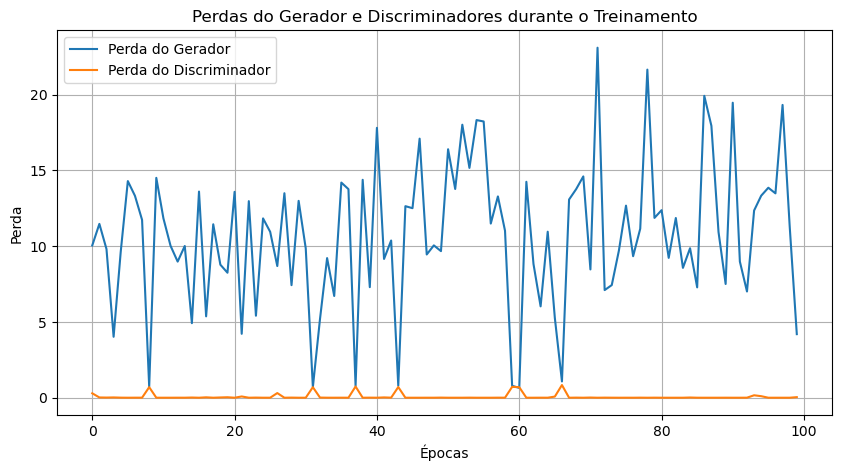

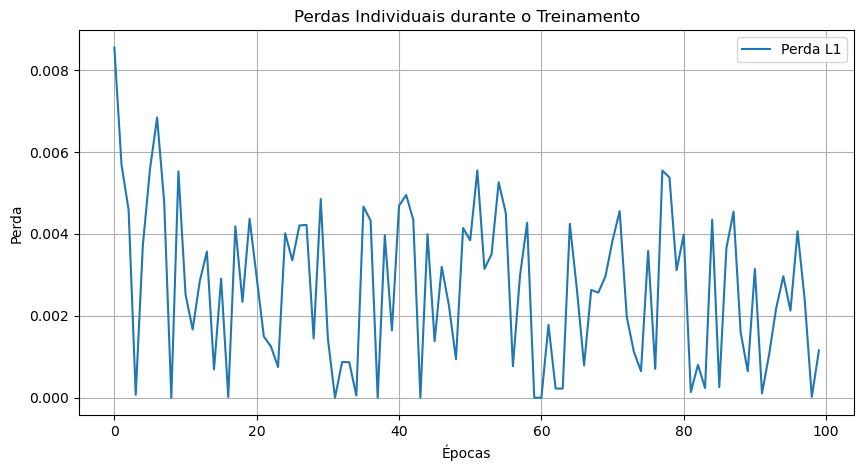

In [40]:
# Plotando as perdas do gerador e dos discriminadores
plt.figure(figsize=(10,5))
plt.title("Perdas do Gerador e Discriminadores durante o Treinamento")
plt.plot(G_losses, label="Perda do Gerador")
plt.plot(D_losses, label="Perda do Discriminador")
plt.xlabel("Épocas")
plt.ylabel("Perda")  
plt.grid()
plt.legend()
plt.savefig('Pix2pix(G and D Seismic data).png')
plt.show()

# Plotando as perdas de identidade, GAN e ciclo
plt.figure(figsize=(10,5))
plt.title("Perdas Individuais durante o Treinamento")
plt.plot(L1_losses, label="Perda L1")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.grid()
plt.legend()
plt.savefig('Pix2pix (L1-Siesmic data).png')
plt.show()

In [41]:
torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'generator_optimizer_state_dict': optimizer_G.state_dict(),
    'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
    'epoch': epoch
}, 'pix2pix_checkpoint.pth')

checkpoint = torch.load('pix2pix_checkpoint.pth', weights_only=True)

G = GeneratorUnet(1) 
D = Discriminator(2) 

# Carregue o estado do gerador e discriminador
G.load_state_dict(checkpoint['generator_state_dict'])
D.load_state_dict(checkpoint['discriminator_state_dict'])

# Carregue os otimizadores
optimizer_G.load_state_dict(checkpoint['generator_optimizer_state_dict'])
optimizer_D.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

if cuda:
    G = G.cuda()
    D = D.cuda()

C:\Users\Matheus\AppData\Local\Temp\ipykernel_3944\1018027933.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('pix2pix_checkpoint.pth')


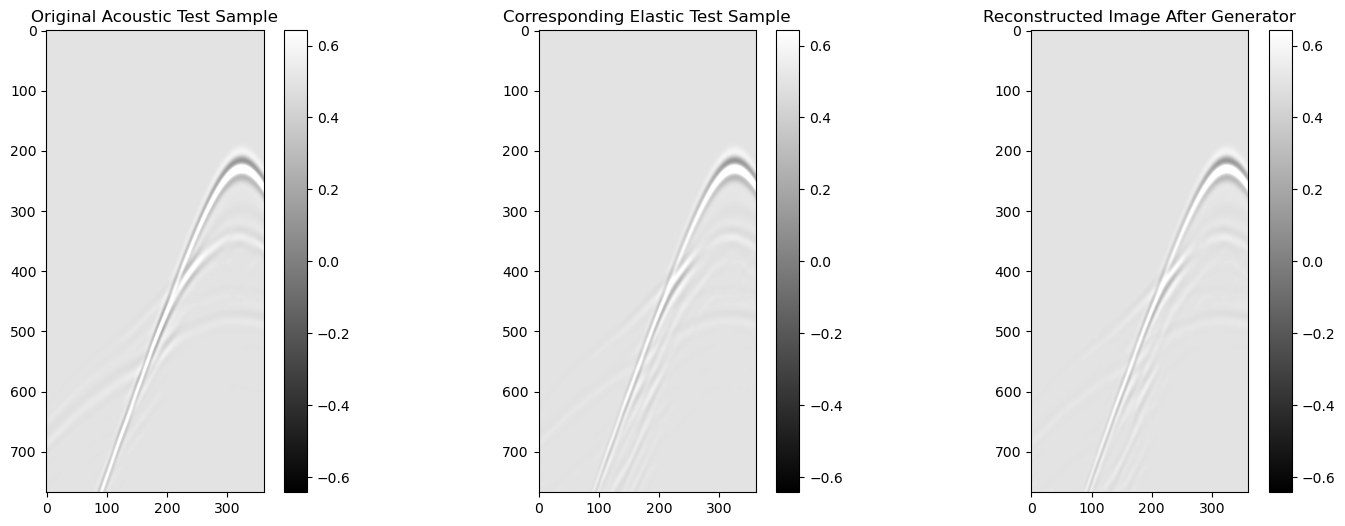

In [51]:
def split_into_patches(data, patch_size=256, vertical_overlap=0, horizontal_overlap=0):
    # Splitting 1024x768 matrices into 256x256 patches and storing their positions
    patches = []
    positions = []
    step_h = patch_size - horizontal_overlap
    step_v = patch_size - vertical_overlap
    for i in range(0, data.shape[0] - patch_size + 1, step_v):
        for j in range(0, data.shape[1] - patch_size + 1, step_h):
            patch = data[i:i+patch_size, j:j+patch_size]
            if patch.shape == (patch_size, patch_size):
                patches.append(patch)
                positions.append((i, j))  # Store positions as (row, col)
    return np.array(patches), positions

def reconstruct_from_patches(patches, positions, original_shape, patch_size=256):
    # Reconstruct the original image from patches using stored positions
    reconstructed = np.zeros(original_shape)

    for idx, (patch, (i, j)) in enumerate(zip(patches, positions)):
        # Se o patch ainda for um tensor PyTorch, desconecte-o do grafo computacional e converta para NumPy
        if isinstance(patch, torch.Tensor):
            patch = patch.detach().numpy()  # Detach and convert to NumPy array

        # Remova o canal extra (dimensão 1) se ele existir
        if patch.shape[-1] == 1:
            patch = np.squeeze(patch, axis=-1)
        
        # Coloque o patch de volta na posição original
        reconstructed[i:i+patch_size, j:j+patch_size] = patch

    return reconstructed

## Process the test data
for test_batch in test_dl:
    
    test_acustic, test_elastic = test_batch[0], test_batch[1]  # Assuming test_batch[0] is acoustic and test_batch[1] is elastic
    test_acustic = test_acustic.squeeze(0).squeeze(0)  # Remove batch dimension
    test_elastic = test_elastic.squeeze(0).squeeze(0)  # Remove batch dimension

    # Split acoustic test data into patches
    patches, positions = split_into_patches(test_acustic.numpy(), patch_size=256, vertical_overlap=0, horizontal_overlap=151)

    # Pass each acoustic patch through the generator G
    generated_patches = []
    for patch in patches:
        patch_tensor = torch.tensor(patch).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        patch_tensor = patch_tensor.to(device)  # Send to GPU if available
        generated_patch = G(patch_tensor)
        # generated_patch = (generated_patch.squeeze(0).cpu().permute(1, 2, 0) + 1) / 2 
        generated_patch = generated_patch.squeeze(0)
        generated_patches.append(generated_patch)

    # Reconstruct the image from the generated patches
    reconstructed_image = reconstruct_from_patches(generated_patches, positions, (768, 361), patch_size=256)

    # Definir o percentual
    perc = 99
    # Calcular os valores de vmax e vmin com base nos dados
    vmax = np.percentile(np.abs(test_acustic), perc)
    vmin = -vmax

    # Visualize the original acoustic, elastic, and reconstructed image
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Acoustic Test Sample")
    plt.imshow(test_acustic, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Corresponding Elastic Test Sample")
    plt.imshow(test_elastic, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed Image After Generator")
    plt.imshow(reconstructed_image, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.savefig('Acoustic to Elastic (Pós-treino)')
    plt.show()
    break  # Process only one batch for visualization